In [16]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [17]:
def load_data(file_name):
    curr_file = os.path.join(os.getcwd().replace('eda', 'data'), file_name)
    return pd.read_csv(curr_file, delimiter=";")

In [18]:
# Reload the dataset with the correct delimiter
data = load_data('records.csv')

# Display the first few rows of the dataset
data.head()

,colesterol_total,idade,glicemia,desfecho
0,236,25,134,-1
1,183,23,156,-1
2,176,28,89,-1
3,231,60,85,-1
4,238,80,86,1


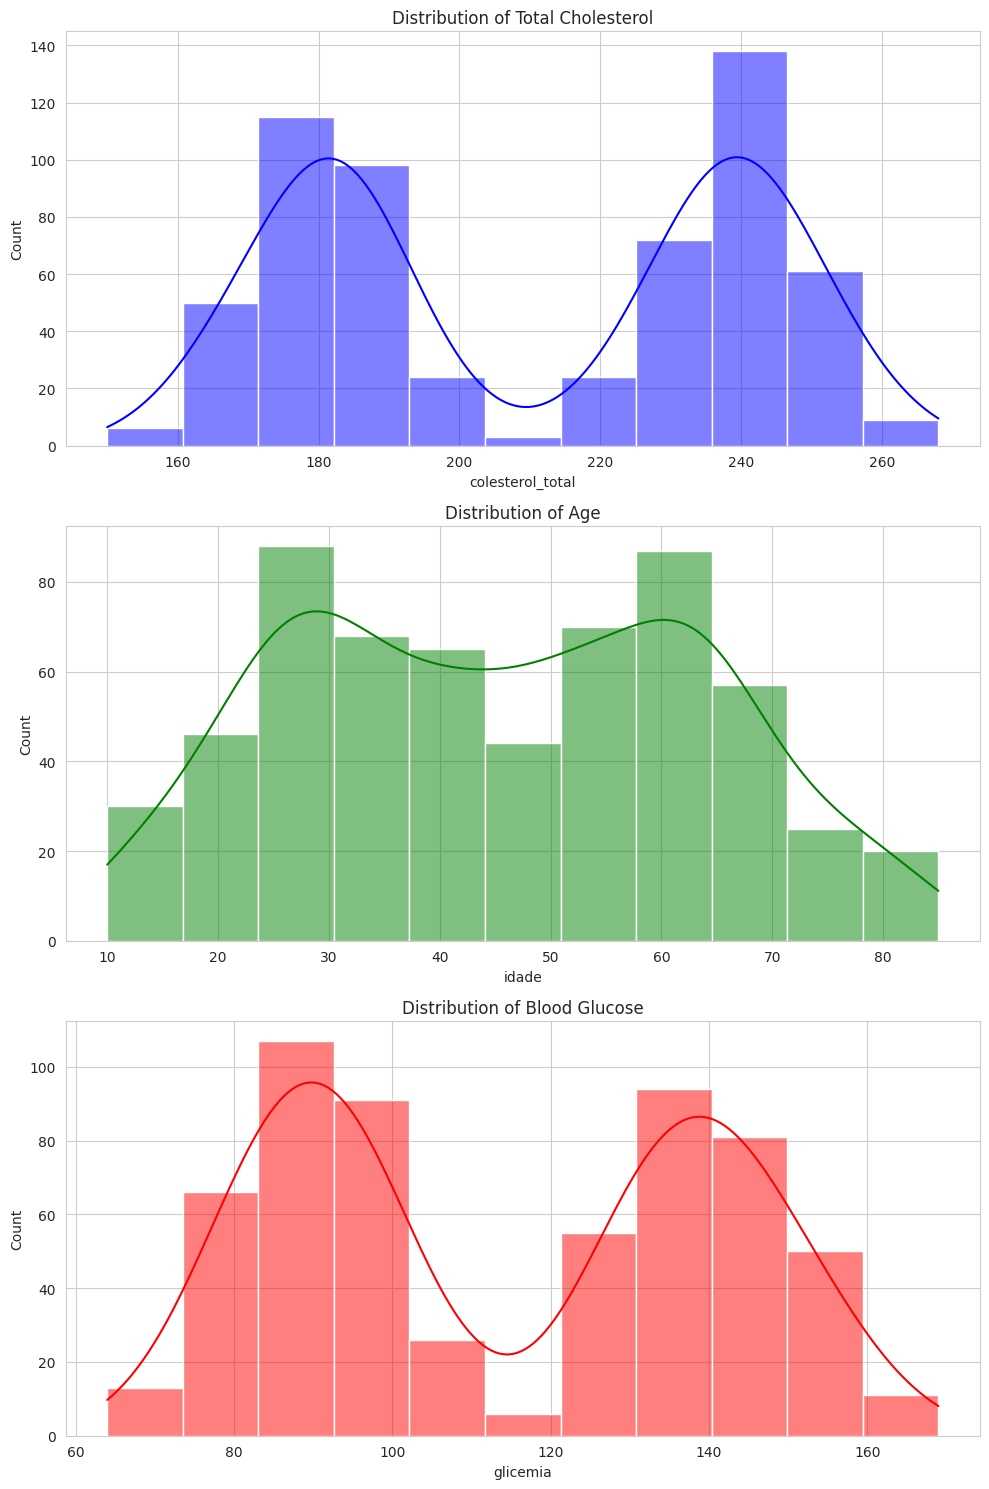

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot distributions of the numerical features
sns.histplot(data=data, x="colesterol_total", kde=True, ax=axs[0], color="blue").set_title("Distribution of Total Cholesterol")
sns.histplot(data=data, x="idade", kde=True, ax=axs[1], color="green").set_title("Distribution of Age")
sns.histplot(data=data, x="glicemia", kde=True, ax=axs[2], color="red").set_title("Distribution of Blood Glucose")

# Adjust the layout
plt.tight_layout()
plt.show()

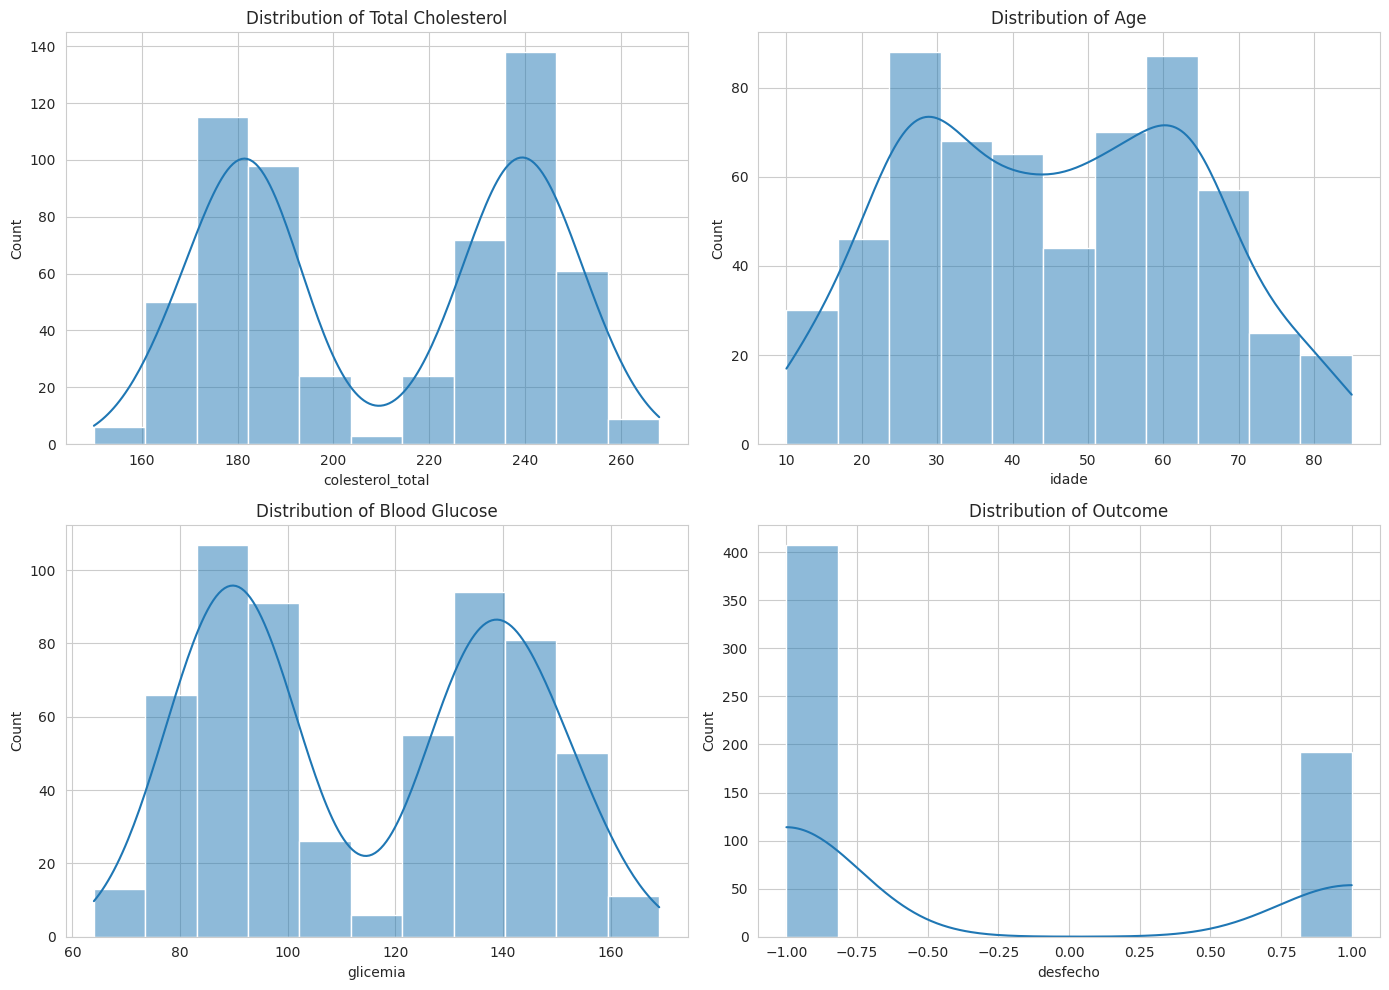

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot histograms for colesterol_total, idade, and glicemia
sns.histplot(data['colesterol_total'], kde=True, ax=ax[0, 0]).set_title('Distribution of Total Cholesterol')
sns.histplot(data['idade'], kde=True, ax=ax[0, 1]).set_title('Distribution of Age')
sns.histplot(data['glicemia'], kde=True, ax=ax[1, 0]).set_title('Distribution of Blood Glucose')

# Plot a bar plot for desfecho
sns.histplot(data['desfecho'], kde=True, ax=ax[1, 1]).set_title('Distribution of Outcome')

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

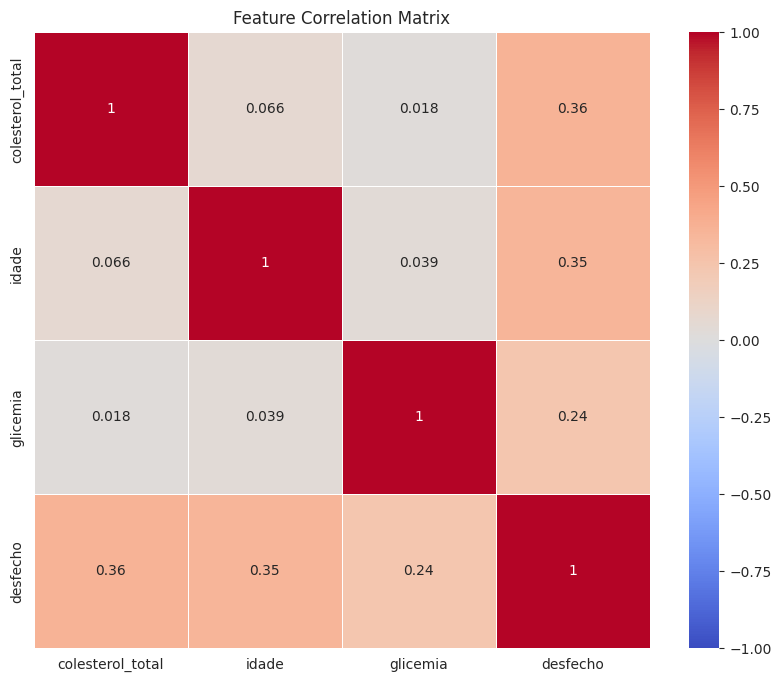

In [33]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into features (X) and target (y)
X = data.drop('desfecho', axis=1)
y = data['desfecho']

# Standardizing the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
import numpy as np

# Setting up the Linear Regression model
lr = LinearRegression()

# Using 5-Fold Cross Validation
predicted_scores = cross_val_predict(lr, X_standardized, y, cv=5, method='predict')

# Thresholding the predictions to get binary classification outcomes
predicted_labels = np.where(predicted_scores > 0, 1, -1)

# Getting the ROC curve values
fpr, tpr, thresholds = roc_curve(y, predicted_scores)

# Calculating AUC
roc_auc = roc_auc_score(y, predicted_scores)

# Calculating other model statistics
accuracy = accuracy_score(y, predicted_labels)
classification_rep = classification_report(y, predicted_labels)
confusion_mat = confusion_matrix(y, predicted_labels)


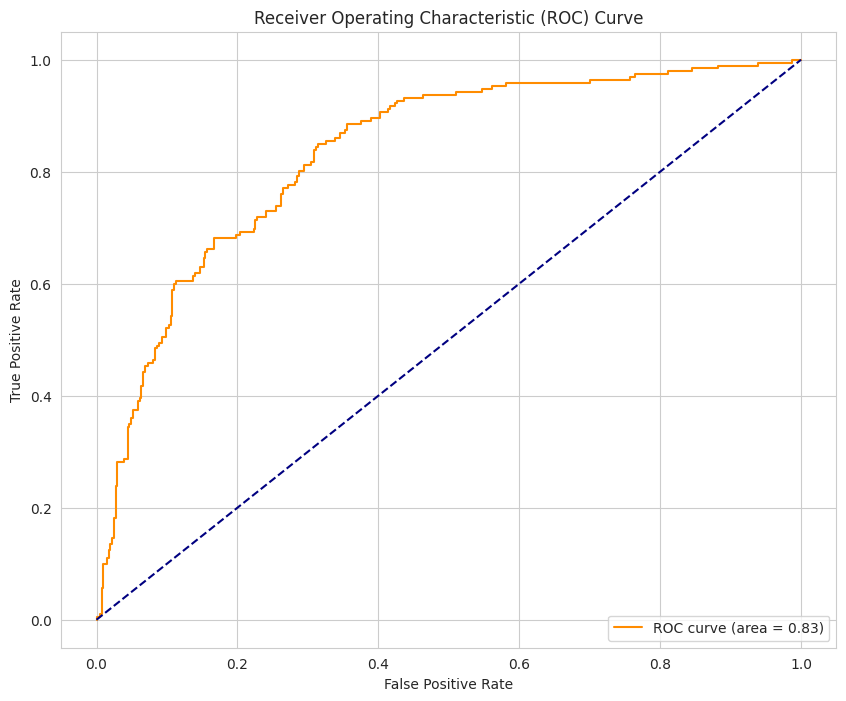

In [37]:
# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

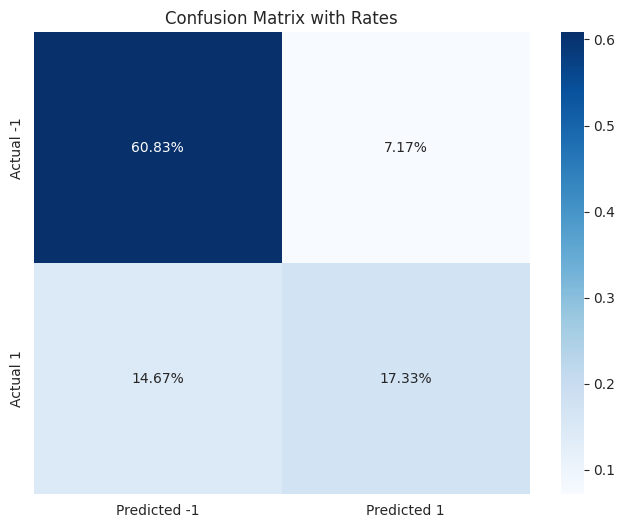

In [38]:
import seaborn as sns

# Calculate rates for the confusion matrix
total = np.sum(confusion_mat)
rate_matrix = confusion_mat / total

# Plotting the confusion matrix with rates
plt.figure(figsize=(8, 6))
sns.heatmap(rate_matrix, annot=True, cmap='Blues', fmt=".2%", 
            xticklabels=['Predicted -1', 'Predicted 1'], 
            yticklabels=['Actual -1', 'Actual 1'])
plt.title('Confusion Matrix with Rates')
plt.show()


In [39]:
# Convert the classification report to a dictionary
report_dict = classification_report(y, predicted_labels, output_dict=True)

# Convert the dictionary to a dataframe
report_df = pd.DataFrame(report_dict).transpose()

# Drop the support column as it's just the count of occurrences
report_df = report_df.drop(columns='support')

report_df

,precision,recall,f1-score
-1,0.805740,0.894608,0.847851
1,0.707483,0.541667,0.613569
accuracy,0.781667,0.781667,0.781667
macro avg,0.756611,0.718137,0.730710
weighted avg,0.774297,0.781667,0.772881


In [42]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features up to the 5th degree
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(X_standardized)

# Checking the shape to see how many features we have now
X_poly.shape


(600, 55)

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest classifier to determine feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_poly, y)

# Get feature importances from the model
feature_importances = rf.feature_importances_

# Sort the features based on importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Display the top 20 features and their importances
top_features = [(poly.get_feature_names_out()[i], feature_importances[i]) for i in sorted_idx[:20]]

top_features_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])

top_features_df

,Feature,Importance
0,x1^3 x2^2,0.035146
1,x0^3,0.034113
2,x0 x2^2,0.029180
3,x0^5,0.028888
4,x0 x2^4,0.027471
5,x1^3,0.027256
6,x0^3 x2^2,0.026551
7,x0^3 x1^2,0.025906
8,x0,0.025338
9,x1^5,0.024046


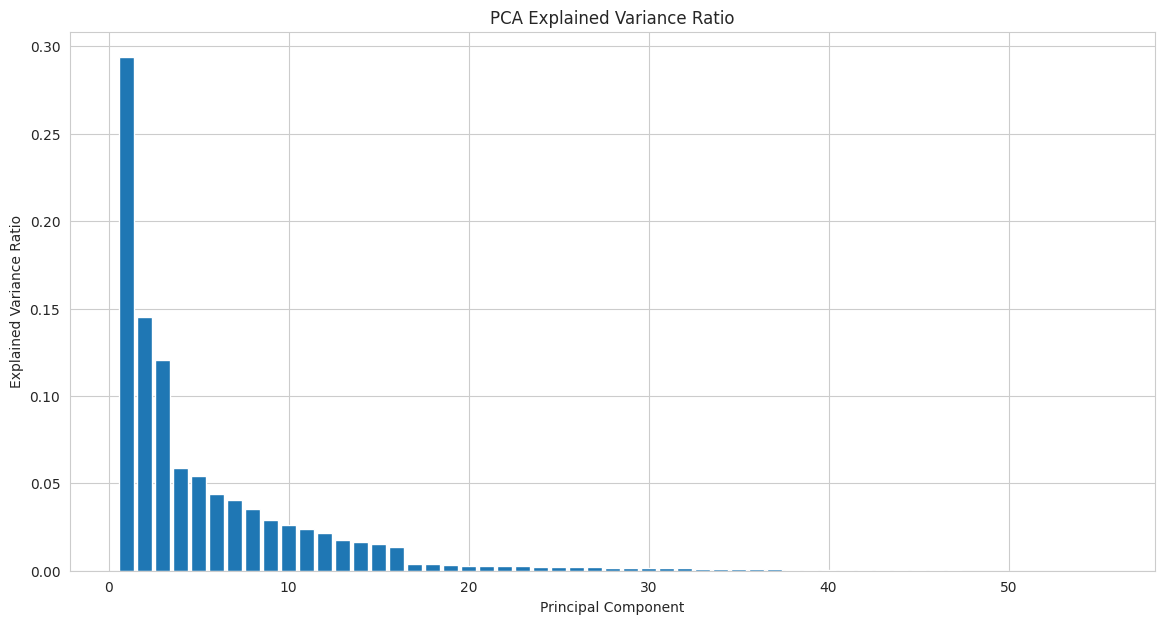

array([0.29367048, 0.4385652 , 0.5591048 , 0.61774319, 0.67175251,
       0.7155146 , 0.756233  , 0.79141331, 0.82040616, 0.84655829])

In [45]:
from sklearn.decomposition import PCA

# Applying PCA to the polynomial features dataset
pca = PCA()
X_pca = pca.fit_transform(X_poly)

# Getting the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the explained variance for each principal component
plt.figure(figsize=(14, 7))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

# Return the total variance explained by the first few components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance[:10]  # Displaying the cumulative variance for the first 10 components


In [47]:
# Extract the first 10 principal components
X_pca_reduced = X_pca[:, :10]

# Using 5-Fold Cross Validation with Linear Regression on the reduced PCA dataset
predicted_scores_pca = cross_val_predict(lr, X_pca_reduced, y, cv=5, method='predict')

# Thresholding the predictions to get binary classification outcomes
predicted_labels_pca = np.where(predicted_scores_pca > 0, 1, -1)

# Getting the ROC curve values
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y, predicted_scores_pca)

# Calculating AUC
roc_auc_pca = roc_auc_score(y, predicted_scores_pca)

# Calculating other model statistics
accuracy_pca = accuracy_score(y, predicted_labels_pca)
classification_rep_pca = classification_report(y, predicted_labels_pca, output_dict=True)
confusion_mat_pca = confusion_matrix(y, predicted_labels_pca)


In [49]:
from imblearn.over_sampling import SMOTE

# Extracting the most important features based on the feature importances
top_feature_indices = sorted_idx[:10]
X_poly_top_features = X_poly[:, top_feature_indices]

# Apply SMOTE to oversample the positive class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_poly_top_features, y)

# Checking the distribution of the target variable after SMOTE
y_resampled.value_counts()

desfecho
-1    408
 1    408
Name: count, dtype: int64

In [51]:
import pandas as pd

# Convert the resampled data to a DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=[f'Feature_{i}' for i in range(X_resampled.shape[1])])

# Add the resampled target variable to the DataFrame
resampled_df['Outcome'] = y_resampled

# Save the balanced dataset to a CSV file
resampled_df.to_csv('balanced_dataset.csv', index=False)
